# 第二章　確率分布と統計モデルの最尤推定

In [1]:
import requests
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

# 2.1 種子数の統計モデリング

In [17]:
# 教科書のデータを手動で作成
flower_data = [2,2,4,6,4,5,2,3,1,2,0,4,3,3,3,3,4,2,7,2,4,3,3,3,4,3,7,5,3,1,7,6,4,6,5,2,4,7,2,2,6,2,4,5,4,5,1,3,2,3]

# pandasを使ってsummaryを出力
pd.DataFrame(pd.Series(flower_data).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,50.0,3.56,1.72804,0.0,2.0,3.0,4.75,7.0


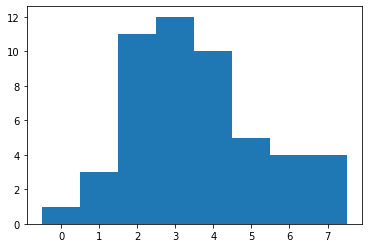

In [20]:
# ヒストグラムを描画
plt.hist(flower_data, bins=np.arange(-0.5, 8))
plt.show()

In [32]:
# https://www.self-study-blog.com/dokugaku/python-pandas-numpy-frequency-table/
# このサイトを参考に度数分布表を作成する関数を作成
def frequency_table(data, stur=False):
  data_len = len(data)
  print('データ数：', data_len)
  #スタージェンスの公式でbinの数を求める
  if stur is True:
    b = round(1 + np.log2(data_len))
    hist, bins = np.histogram(data, bins=b)
  else:
    hist, bins = np.histogram(data)
  #データフレーム作成
  df = pd.DataFrame({'以上': bins[:-1],'以下': bins[1:],'階級値': (bins[:-1]+bins[1:])/2,'度数': hist})
  #相対度数の計算
  df['相対度数'] = df['度数'] / data_len
  #累積度数の計算
  df['累積度数'] = np.cumsum(df['度数'])
  #累積相対度数の計算
  df['累積相対度数'] = np.cumsum(df['相対度数'])
  return df

In [27]:
frequency_table(flower_data)

データ数： 50


,以上,以下,階級値,度数,相対度数,累積度数,累積相対度数
0,0.0,0.7,0.35,1,0.02,1,0.02
1,0.7,1.4,1.05,3,0.06,4,0.08
2,1.4,2.1,1.75,11,0.22,15,0.30
3,2.1,2.8,2.45,0,0.00,15,0.30
4,2.8,3.5,3.15,12,0.24,27,0.54
5,3.5,4.2,3.85,10,0.20,37,0.74
6,4.2,4.9,4.55,0,0.00,37,0.74
7,4.9,5.6,5.25,5,0.10,42,0.84
8,5.6,6.3,5.95,4,0.08,46,0.92
9,6.3,7.0,6.65,4,0.08,50,1.00


In [28]:
# 標本分散を出力
np.var(flower_data)

2.9264000000000006

In [30]:
# 標本標準偏差を出力
np.std(flower_data)

1.710672382427448

In [31]:
# 標本標準偏差 = √標本分散

np.sqrt(np.var(flower_data))

1.710672382427448

# 2.2 データと確率分布の対応関係を眺める

**確率分布とは**<br>
確率変数の値とそれが出現する確率を対応させたもの<br>
今回だと、ある植物個体iの種子数$y_i$のように個体ごとにばらつく変数

種子数の分布はポアソン分布に対応するらしいので、とりあえずポアソン分布で色々考えていく

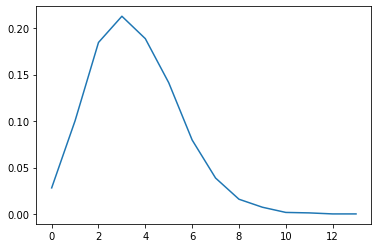

In [35]:
# 平均3.56のポアソン分布を作成
poisson_values = np.random.poisson(lam=3.56, size=10000)
prod = (pd.value_counts(poisson_values) / 10000).sort_index()
plt.plot(prod.index, prod.values)
plt.show()

⬆︎<br>
ある植物の種子数がゼロである確率は0.03くらい<br>
一番確率が高くなるのは1個体に3個の種子を持つときで確率は0.21くらい

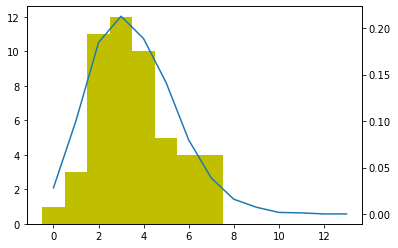

In [37]:
# ヒストグラムと重ねる
fig, ax1 = plt.subplots()
plt.hist(flower_data, bins=np.arange(-0.5, 8), color=['y'])
ax2 = ax1.twinx()
ax2.plot(prod)
plt.show()

ちゃんと種子数のヒストグラムとポアソン分布が対応しているように見える

# 2.3 ポアソン分布とは

ポアソン分布の確率分布は以下の式で表される
$$
p(y | \lambda) = \frac{\lambda^{y}exp(-\lambda)}{y!}
$$

平均が$\lambda$の場合にポアソン分布に従う確率変数がyになる確率<br>
ポアソン分布は以下の性質を持つ
- $y\in\{0,1,2,3,...,\infty\}$の値をとり、すべてのyに対して和をとると1になる　$\sum_{y=0}^{\infty}p(y | \lambda) = 1$
- 確率分布の平均は$\lambda$
- 分散と平均は等しい

<br>今回、花の種子数データに対してポアソン分布を選択した理由は以下
- データに含まれる値が非負の整数（カウントデータである）
- $y_i$に下限(= 0)は存在するが、上限はよくわからない
- この観測データにおいて、分散と平均が大体等しい

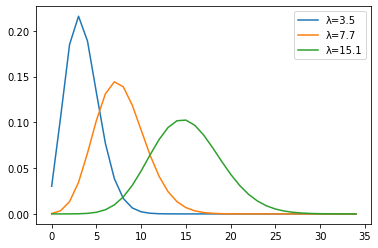

In [41]:
# 様々な平均(λ)のポアソン分布。λ∈{3.5, 7.7, 15.1}
prod1 = [poisson.pmf(i, 3.5) for i in range(35)]
prod2 = [poisson.pmf(i, 7.7) for i in range(35)]
prod3 = [poisson.pmf(i, 15.1) for i in range(35)]

plt.plot(range(35), prod1, label='λ=3.5')
plt.plot(range(35), prod2, label='λ=7.7')
plt.plot(range(35), prod3, label='λ=15.1')

plt.legend(loc='best')

plt.show()

# ポアソン分布のパラメータ最尤推定

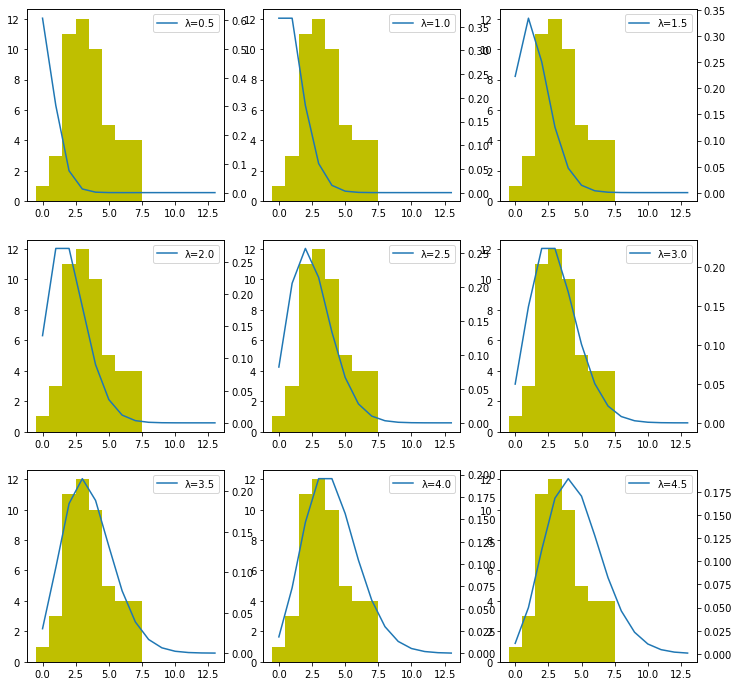

In [40]:
# λが0.5から4.0まで0.5刻みでλを変え、各λのポアソン分布をプロットする
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(9):
    lam = 0.5*(i+1)
    prod = [poisson.pmf(i, lam) for i in range(14)]
    
    ax1 = axes[int(i/3), i%3]
    ax1.hist(flower_data, bins=np.arange(-0.5, 8), color=['y'])
    
    ax2 = ax1.twinx()
    ax2.plot(prod, label='λ={:.1f}'.format(lam))
    ax2.legend(loc='best')
plt.show()